##  Study on how to give initial data. 

We want to have a very isotropic data with a given frequency, or perhaps a distribution (thermal?) for $phi$ and its time derivative. Here
We do in 2dim.

We first create a distribution of values on Fourier space both for $ϕ $ and its time derivative, $\phi_t$.
I think we need a thermal distribution, that is we fix a temperature and put particles at that temperature.
That is we shall use the $\omega = |k|$ rule, we take positive so as to have particles and not antiparticles.



In [3]:
using Plots
using Distributions
using FFTW
using LinearAlgebra
using Revise
using Base.Threads
#import Pkg; Pkg.add("HDF5")
using HDF5
using SummationByPartsOperators

In [4]:
#includet("../PIC/PIC-1D/aux_functions/inidat_aux_functions.jl")
#includet("../PIC/PIC-1D/aux_functions/aux_functions.jl")
includet("../PIC-1D/aux_functions/inidat_aux_functions.jl")
includet("../PIC-1D/aux_functions/aux_functions.jl")
includet("local_aux_functions.jl")

We first look at the scheme for a distribution which resembles a delta function $k$ in Fourier space.
It gives a rather homogeneous distribution is space.

In [5]:
#J = (501,501,501)
#J = (440,440,440)
J = (110,110,110) #small
Box_x = [-220.0, 220.0, -220.0, 220.0, -220.0, 220.0]
Box_x = [-55.0, 55.0, -55.0, 55.0, -55.0, 55.0]
dx = differentials(Box_x,J)
κ = 2π./(Box_x[2:2:end] - Box_x[1:2:end-1])
V = volume(Box_x)
ϕ = Array{ComplexF64}(undef,J...)
ϕ_t = copy(ϕ)
#g = copy(ϕ)
#g_t = copy(ϕ)
#g_p = copy(ϕ)

m = 1
m2 = m^2

N = 1000 #number of particles
 
# k0= 500; δ = 1000 # para J=2001
k0 = 1; δ = 0.5


0.5

In [ ]:
dx

In [6]:
k0 = 1.2; δ = 0.5 #coarse k0=0.5
h_pars = k0
f_pars = (k0, δ)
#g, g_p = get_fourier_data(f,Box_x,J,1,f_pars)
g, g_t, g_p = get_fourier_data(h,Box_x,J,1,h_pars)

([0.7282424760555971 + 0.2542022700318159im 0.10266588638436669 - 0.7638372910915335im … -0.6110058770165668 - 0.466672269765464im -0.7470531690275599 - 0.18947098494233894im; -0.5526663071359345 - 0.537166309857449im 0.4351788688555814 + 0.6353294803357492im … 0.4267545724413962 + 0.6387817598869064im 0.42410687730982083 + 0.6427733294876421im; … ; 0.7536095677281511 - 0.15226230178682815im 0.6769910017303354 - 0.36310437265338624im … -0.2844807602022806 - 0.7116254367963746im 0.7676684783423658 - 0.029098268391239933im; -0.7234045396510583 - 0.26584499901517844im -0.22715703928636444 - 0.7358151099187685im … 0.1205974908316676 - 0.7586948313182039im 0.020278705494281724 - 0.7698135947004265im;;; -0.6688657550996363 - 0.3828920123796436im 0.4193228106958856 + 0.645904464229981im … -0.7382631547182352 + 0.21243614628714028im 0.6391786175980639 + 0.42950540309470425im; -0.6615805282670864 - 0.3941261233411956im -0.6895629264127835 - 0.3414210676394858im … 0.7378641861908969 + 0.21159635

In [7]:

@show sum(abs.(g))*prod(κ)
kx, ky, kz = get_frequencies(Box_x,J)
#kx_p = sort(kx)
#ky_p = sort(ky)
#kz_p = sort(kz)
#heatmap(ky_p,kx_p,real.(g_p[:,:,J[3]÷2]), aspectratio = 1)
#surface(ky_p,kx_p,real.(g[:,:]), aspectratio = 1)


sum(abs.(g)) * prod(κ) = 4.820538267000387


([0.0, 0.057119866428905326, 0.11423973285781065, 0.17135959928671599, 0.2284794657156213, 0.28559933214452665, 0.34271919857343197, 0.3998390650023373, 0.4569589314312426, 0.514078797860148  …  -0.5711986642890533, -0.514078797860148, -0.4569589314312426, -0.3998390650023373, -0.34271919857343197, -0.28559933214452665, -0.2284794657156213, -0.17135959928671599, -0.11423973285781065, -0.057119866428905326], [0.0, 0.057119866428905326, 0.11423973285781065, 0.17135959928671599, 0.2284794657156213, 0.28559933214452665, 0.34271919857343197, 0.3998390650023373, 0.4569589314312426, 0.514078797860148  …  -0.5711986642890533, -0.514078797860148, -0.4569589314312426, -0.3998390650023373, -0.34271919857343197, -0.28559933214452665, -0.2284794657156213, -0.17135959928671599, -0.11423973285781065, -0.057119866428905326], [0.0, 0.057119866428905326, 0.11423973285781065, 0.17135959928671599, 0.2284794657156213, 0.28559933214452665, 0.34271919857343197, 0.3998390650023373, 0.4569589314312426, 0.51407

In [8]:
#ifft(g,J...)
p_i = plan_ifft(g; flags=FFTW.ESTIMATE, timelimit=Inf);

In [9]:
ϕ = p_i*g*sqrt(prod(J));
ϕ_t = p_i*g_t*sqrt(prod(J));


In [10]:

sum(ϕ.*conj.(ϕ))/prod(J)

0.01295829551583351 + 0.0im

In [11]:

@show norm(ϕ)
@show mean(ϕ)
@show var(ϕ);
@show n(ϕ,ϕ_t,Box_x,J);

norm(ϕ) = 131.3297046809076
mean(ϕ) = 0.0006312290516532644 + 0.00022033850416058393im
var(ϕ) = 0.012957858252092138
n(ϕ, ϕ_t, Box_x, J) = (28215.735149328884, 0.02119889943600968)


In [16]:
p = 4 #polinomial order
percent = 0.550 #0.6 goes up to the border in poli_cut use 0.550 for step_cut
δ = 0.3 #less than 1!
x,y,z = get_coords(Box_x,J)
#ϕ_h_cut = polinomial_cut(ϕ,Box_x,J,p,percent);
#ϕ_h_step_cut = step_cut(ϕ,Box_x,J,p,percent,δ);
#heatmap(x,y,real.(ϕ_h_step_cut[:,:,J[3]÷2]), aspectratio=1)
#heatmap(real.(ϕ_h_cut[J[1]÷2,:,:]), aspectratio=1)
#heatmap(real.(ϕ_h_cut[:,J[2]÷2,:]), aspectratio=1)
#heatmap(imag.(ϕ[:,J[2]÷2,:]), aspectratio=1)
#surface(x,y,real.(ϕ_h_step_cut[:,:,J[3]÷2]), aspectratio=1)
#png("h_cut.png")

([-55.0, -54.0, -53.0, -52.0, -51.0, -50.0, -49.0, -48.0, -47.0, -46.0  …  45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0], [-55.0, -54.0, -53.0, -52.0, -51.0, -50.0, -49.0, -48.0, -47.0, -46.0  …  45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0], [-55.0, -54.0, -53.0, -52.0, -51.0, -50.0, -49.0, -48.0, -47.0, -46.0  …  45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0])

In [13]:
#ϕ_h_cut = polinomial_cut(ϕ,Box_x,J,8);
#ϕ_t_h_cut = polinomial_cut(ϕ_t,Box_x,J,8);

ϕ_h_cut = step_cut(ϕ,Box_x,J,p,percent,δ)
ϕ_t_h_cut = step_cut(ϕ_t,Box_x,J,p,percent,δ);


In [14]:
(π2,∇2,V) = get_rho(ϕ_h_cut,ϕ_t_h_cut,Box_x,J);

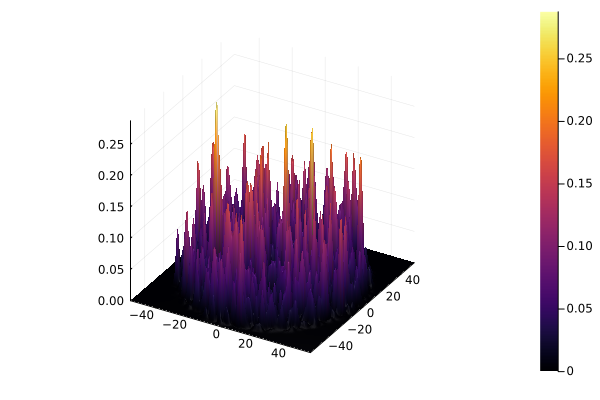

In [17]:
surface(x,y,π2[:,:,J[3]÷2])

In [ ]:

N_fields = 7 #Int32(1)

x, y, z = get_coords(Box_x,J)

#= this data has already an extra point added so as to be symmetric. That is in each dimension we
add an extra point and put there the data from the other extreme. 
=#
load_data_full_h5("data_3d_h_step_cut_small",Box_x,J,ϕ_h_cut,ϕ_t_h_cut,N_fields)
# Open an HDF5 file in write mode


In [ ]:
data = h5open("data_3d_h_step_cut_small.h5", "r")

In [ ]:
var0 = read(data["var0"])
heatmap(x,y,var0[:,:,J[3]÷2], aspectratio=1)
#heatmap(x,y,real.(ϕ_h_cut)[:,:,J[3]÷2], aspectratio=1)

## Thermal distribution

We use a relativistic thermal distribution. I guess we are setting the mass to 1 but I don't know the temperature.



In [ ]:
θ = 1.0
m = 1.0
m2 = m^2
norm_rel = 2.0
p_max = 10*θ
Box_p =(-p_max,p_max,-p_max,p_max,-p_max,p_max)
#dp = differentials(Box_p,J)
L = zeros(J...)
L = Box_p[2:2:end] .- Box_p[1:2:end]
f_p = f_p_rel 
f_p_max = f_p_rel_max
par_f_p_1 = (θ,norm_rel,2)
#norm_rel = int_mid_point_f(f_p, par_f_p_1, [20_000,20_000], Box_p)
par_f_p = (θ, norm_rel,2)
interval_p = Box_p


In [ ]:
g_th = fill(0.0+im*0.0,J...)
gt_th = fill(0.0+im*0.0,J...)

N=100000
plt = Plots.scatter(labels=false)
for i in 1:N÷2
    kr = random_sampling_from_distribution_D(f_p,f_p_max,par_f_p,interval_p)
    j = get_index_p(kr,J,L)
    jm = get_index_p(-kr,J,L)
    if (abs(j[1]) > J[1] || abs(jm[1])) > J[1] || (abs(j[2]) > J[2] || abs(jm[2])) > J[2]
        println("j = $j, jm = $jm, kr = $kr")
    end
    #Plots.scatter!(plt,[j[1],jm[1]],[j[2],jm[2]],label=false)
    factor = 1.0/sqrt(2*ω([kr[1],kr[2],kr[3]],m2))
    phase_p = exp(im*rand()*2*π)
    phase_m = exp(im*rand()*2*π)
    g_th[j...] += phase_p*factor
    g_th[jm...] += phase_m*factor
    gt_th[j...] += im*phase_p/factor/2.0
    gt_th[jm...] += 2.0*im*phase_m/factor/2.0
end

#heatmap(real.(g_th))
surface(real.(g_th[30,:,:]))
#plt

In [ ]:
ϕ_th = p_i*g_th*sqrt(prod(J));
ϕt_th = p_i*gt_th*sqrt(prod(J));

In [ ]:
#heatmap(imag.(ϕ_th))
surface(imag.(ϕ_th[30,:,:]))

In [ ]:
#@show sum(ϕ.*conj.(ϕ))*prod(dx)/V

n(ϕ_th,ϕt_th,Box_x,J)

### Localization



In [ ]:
#ϕ_th_cut = polinomial_cut(ϕ_th,Box_x,J,8);
#ϕ_th_step_cut = poli_step
p = 4 #polinomial order
percent = 0.550 #0.6 goes up to the border in poli_cut use 0.550 for step_cut
δ = 0.3 #less than 1!
#x,y,z = get_coords(Box_x,J)

ϕ_th_step_cut = step_cut(ϕ_th,Box_x,J,p,percent,δ)
ϕ_t_th_step_cut = step_cut(ϕt_th,Box_x,J,p,percent,δ)

In [ ]:
surface(real.(ϕ_th_step_cut[101,:,:]) )

### Data transfer

In [ ]:
N_fields = 4.0 #Int32(1)

x, y, z = get_coords(Box_x,J)

# Open an HDF5 file in write mode
h5file = h5open("example_data_3d_gaussian.h5", "w") do file
    write(file, "coord0", x)
    write(file, "coord1", y)
    write(file, "coord2", z)
    write(file, "nvars", [N_fields])
    write(file, "var0", real.(ϕ))
    write(file, "var1", imag.(ϕ))
    write(file, "var2", real.(ϕ_t))
    write(file, "var3", imag.(ϕ_t))
end